# Used car's price prediction

## Описание задачи

Многие знают про маркетплейсы где продаются б/у вещи, на которых есть возможность недорого купить качественную и полезную вещь. Но всегда волнует вопрос - кто и как устанавливает цену, и какие его характеристики больше всего влияют на итоговую стоимость продажи?!  
Вопрос становиться особо актуальным, если речь идет про дорогие товары, например про автомобили!

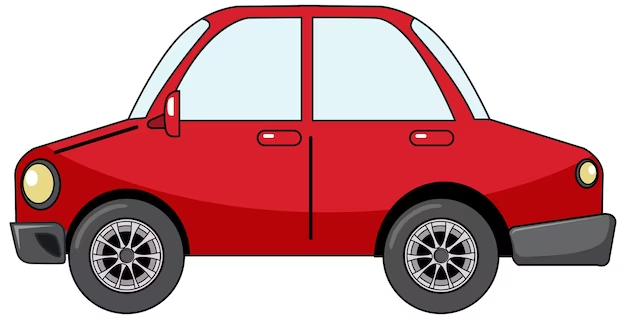

## Импорт библиотек, константы и загрузка данных

In [1]:
%%capture

# установка библиотек (~5 мин)
!pip install association-metrics
!pip install category_encoders -q
!pip install optuna -q
!pip install catboost -q

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import association_metrics as am
import optuna
import pickle 

from category_encoders.ordinal import OrdinalEncoder 
from category_encoders.one_hot import OneHotEncoder
from category_encoders.target_encoder import TargetEncoder 
from category_encoders.leave_one_out import LeaveOneOutEncoder

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_percentage_error as MAPE 

from catboost import CatBoostRegressor

In [3]:
%config InlineBackend.figure_format = "svg"
sns.set_style('whitegrid')

In [4]:
RANDOM_STATE = 42

In [5]:
data = pd.read_csv('https://www.dropbox.com/s/bpr6fm0txtr5zva/used_cars_train.csv?dl=1')
test = pd.read_csv('https://www.dropbox.com/s/pr1nlca9e8ewz3b/used_cars_test.csv?dl=1')

Пока будем работать только с датасетом `data`.

Когда финальная модель будет готова, с помощью нее предскажем цены на `train` (там ответов нет).

## Обзор данных

In [6]:
# смотрим на случайные пять строк таблицы данных
data.sample(5)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
162157,2005,Nissan,Frontier,Nismo,King Cab,automatic,1n6ad06w15c440302,oh,3.1,128936.0,blue,black,wells fargo dealer services,6500,Tue Jan 13 2015 12:00:00 GMT-0800 (PST)
16325,2009,Chevrolet,Impala,LT,Sedan,automatic,2g1wt57k391196628,az,1.0,1.0,white,gray,wells fargo dealer services,2000,Wed Apr 22 2015 05:00:00 GMT-0700 (PDT)
382871,2004,Chrysler,Sebring,Touring,Convertible,automatic,1c3el55r44n218568,md,4.0,88019.0,white,black,darcars toyota,1600,Tue Feb 17 2015 01:30:00 GMT-0800 (PST)
303812,2013,Nissan,Maxima,3.5 SV,Sedan,automatic,1n4aa5apxdc824012,fl,4.2,59827.0,white,black,the hertz corporation,15201,Tue Mar 03 2015 01:30:00 GMT-0800 (PST)
92248,2010,Volkswagen,Routan,SE,Minivan,automatic,2v4rw3d16ar325128,tx,3.1,68537.0,black,gray,rlb investments,10200,Wed Feb 11 2015 02:20:00 GMT-0800 (PST)


**Описание данных**

**_Признаки_**
- `year` - год производства
- `make` - производитель
- `model` - модель
- `trim` - модификация
- `body` - тип кузова
- `transmission` - тип КПП
- `vin` - идентификатор (вин)
- `state` - штат регистрации
- `condition` - состояние по шкале (1-5)
- `odometer` - пробег в милях
- `color` - цвет кузова
- `interior` - цвет интерьера
- `seller` - продавец
- `saledate` - дата продажи

**_Целевой признак_**
- `sellingprice` - стоимость продажи

In [7]:
# сводка о типах данных и количестве ненулевых значений в каждом столбце
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          440236 non-null  int64  
 1   make          432193 non-null  object 
 2   model         432113 non-null  object 
 3   trim          431899 non-null  object 
 4   body          429843 non-null  object 
 5   transmission  388775 non-null  object 
 6   vin           440236 non-null  object 
 7   state         440236 non-null  object 
 8   condition     430831 non-null  float64
 9   odometer      440167 non-null  float64
 10  color         439650 non-null  object 
 11  interior      439650 non-null  object 
 12  seller        440236 non-null  object 
 13  sellingprice  440236 non-null  int64  
 14  saledate      440236 non-null  object 
dtypes: float64(2), int64(2), object(11)
memory usage: 50.4+ MB


In [8]:
# базовые статистики
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
year,440236.0,2010.040101,3.977945,1982.0,2007.0,2012.0,2013.0,2015.0
condition,430831.0,3.425077,0.949973,1.0,2.7,3.6,4.2,5.0
odometer,440167.0,68344.421604,53542.203908,1.0,28258.0,52098.0,99272.0,999999.0
sellingprice,440236.0,13592.209588,9751.479098,1.0,6900.0,12100.0,18200.0,230000.0


In [9]:
# базовые статистики категориальных значений
data.describe(include = ['object']).transpose()

,count,unique,top,freq
make,432193,92,Ford,73708
model,432113,959,Altima,15454
trim,431899,1922,Base,43853
body,429843,85,Sedan,157639
transmission,388775,2,automatic,375061
vin,440236,440236,2fmdk3jc4bba41556,1
state,440236,38,fl,65618
color,439650,20,black,87115
interior,439650,17,black,192442
seller,440236,13025,nissan-infiniti lt,15823


In [10]:
# наличие дубликатов
data.duplicated().sum()

0

## Предобработка данных

Выделим целевую переменную `sellingprice` в отдельную переменную `y`, а `X` - матрица объект-признак.

In [11]:
X = data.drop('sellingprice', axis=1) 
y = data['sellingprice']

In [12]:
# признак vin не несет смысловой нагрузки, удаляем его
X.drop('vin', axis=1, inplace=True)

### Заполнение пропусков

Заполним пропуски в числовых столбцах средним значением, а в категориальных - пустой категорией

In [13]:
for c in X.columns:
    if X[c].dtype == 'object':
          X[c].fillna("", inplace=True)

In [14]:
for c in X.columns:
    if X[c].dtype != 'object':
          mean = np.mean(X[c])
          X[c].fillna(mean, inplace=True)

### Обработка категориальных признаков - 1

Посмотрим на количество значений в каждой категории

In [15]:
for c in X.columns:
    if X[c].dtype == 'object':
          print(c, len(X[c].unique()))

make 93
model 960
trim 1923
body 86
transmission 3
state 38
color 21
interior 18
seller 13025
saledate 3597


В `saledate` очень много различных значений. Посмотрим почему.

In [16]:
X[['year','saledate']]

,year,saledate
0,2011,Tue Jun 02 2015 02:30:00 GMT-0700 (PDT)
1,2014,Wed Feb 25 2015 02:00:00 GMT-0800 (PST)
2,2012,Wed Jun 10 2015 02:30:00 GMT-0700 (PDT)
3,2003,Wed Jun 17 2015 03:00:00 GMT-0700 (PDT)
4,2007,Tue Feb 03 2015 04:00:00 GMT-0800 (PST)
...,...,...
440231,2013,Tue Jan 20 2015 04:30:00 GMT-0800 (PST)
440232,2014,Wed Feb 11 2015 02:00:00 GMT-0800 (PST)
440233,2008,Tue Mar 03 2015 04:30:00 GMT-0800 (PST)
440234,2014,Wed Jan 14 2015 02:05:00 GMT-0800 (PST)


Обработаем `saledate`:
* сделаем признак `car_age` - возраст машины в годах
* сделаем признак date - месяц+год продажи машины (категориальный)

Исходный признак `saledate` удалим

In [17]:
X['car_age'] = X['saledate'].apply(lambda x: int(x.split(" ")[3])) - X['year']
X['date'] = X['saledate'].apply(lambda x: x.split(" ")[1]+x.split(" ")[3])

X.drop('saledate', axis=1, inplace=True)

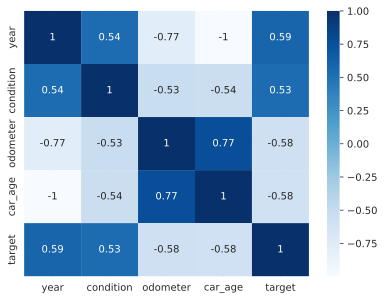

In [18]:
X['target'] = y

cols = X.columns[X.dtypes != 'object']

corr = X[cols].corr()
sns.heatmap(corr, cmap="Blues", annot=True)

X.drop('target', axis=1, inplace=True)

Все числовые признаки важны, запомним это!

Посмотрим на аналог корреляции категориальных признаков

In [19]:
XC = X.apply(
        lambda x: x.astype("category") if x.dtype == "object" else x
        )

cramersv = am.CramersV(XC) 
cramersv.fit()

,make,model,trim,body,transmission,state,color,interior,seller,date
make,1.000000,0.939751,0.765589,0.187426,0.162225,0.080143,0.085610,0.107464,0.398136,0.058950
model,0.939751,1.000000,0.552022,0.617153,0.309671,0.119700,0.145185,0.180423,0.279900,0.084669
trim,0.765589,0.552022,1.000000,0.431589,0.290897,0.129494,0.137931,0.207483,0.259362,0.096575
body,0.187426,0.617153,0.431589,1.000000,0.170281,0.054285,0.071009,0.073597,0.245079,0.297999
transmission,0.162225,0.309671,0.290897,0.170281,1.000000,0.376919,0.063253,0.065353,0.391297,0.032100
state,0.080143,0.119700,0.129494,0.054285,0.376919,1.000000,0.064745,0.062058,0.677723,0.080649
color,0.085610,0.145185,0.137931,0.071009,0.063253,0.064745,1.000000,0.259148,0.232053,0.018267
interior,0.107464,0.180423,0.207483,0.073597,0.065353,0.062058,0.259148,1.000000,0.266665,0.061645
seller,0.398136,0.279900,0.259362,0.245079,0.391297,0.677723,0.232053,0.266665,1.000000,0.282239
date,0.058950,0.084669,0.096575,0.297999,0.032100,0.080649,0.018267,0.061645,0.282239,1.000000


Признаки `make` и `model` сильно связаны, поэтому уберем `make` как менее информативный

In [20]:
X.drop('make', axis=1, inplace=True)

Как посмотреть влияние категориального признака на целевую переменную?  
Здесь лучше всего поможет `scatterplot`!

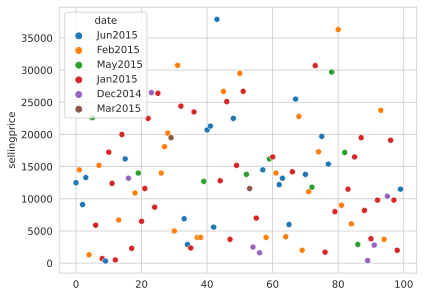

In [21]:
sns.scatterplot(data=X.iloc[:100], x=X.iloc[:100].index, y=y[:100], hue='date');

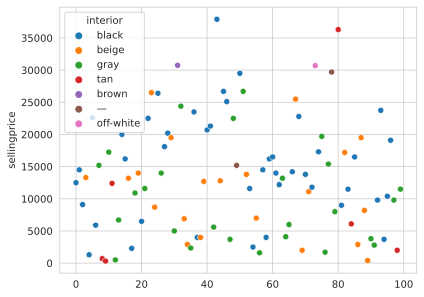

In [22]:
sns.scatterplot(data=X.iloc[:100], x=X.iloc[:100].index, y=y[:100], hue='interior');

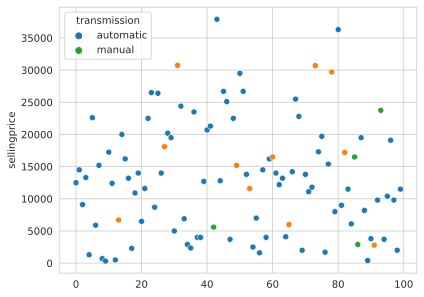

In [23]:
sns.scatterplot(data=X.iloc[:100], x=X.iloc[:100].index, y=y[:100], hue='transmission');

Посмотрим на распределение целевой переменной

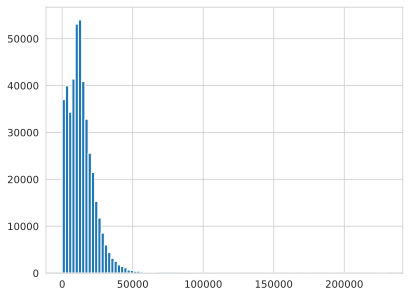

In [24]:
plt.hist(y, bins=100);

Пока мы не будем ничего делать с этим распределением, но известно, что с распределениями, отличными от нормального, большинству моделей сложно работать.

Поэтому при улучшении качества базового решения мы преобразуем это распределение.

### Поиск аномальных значений

In [25]:
cat_cols = X.columns[X.dtypes == 'object']
num_cols = X.columns[X.dtypes != 'object']

year


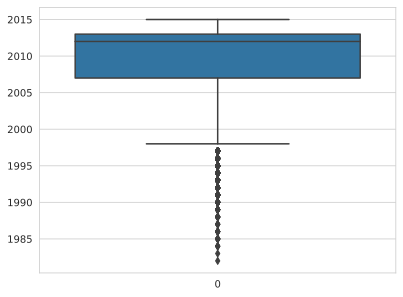

condition


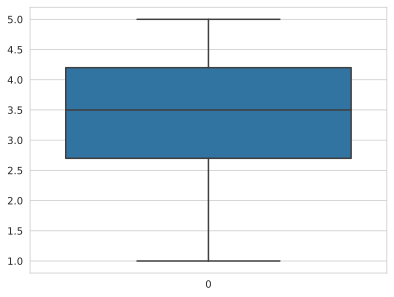

odometer


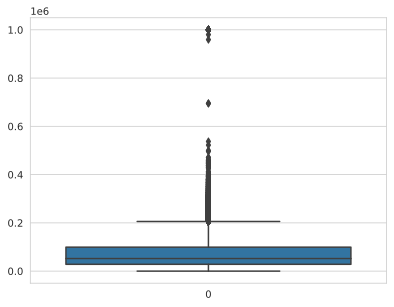

car_age


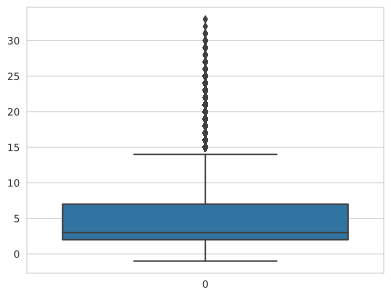

In [26]:
for col in num_cols:
    print(col)
    sns.boxplot(X[col])
    plt.show()

In [27]:
X[X['odometer'] > 800000][['car_age','odometer']]

,car_age,odometer
6069,3,999999.0
11122,11,999999.0
12368,9,999999.0
14897,8,999999.0
17341,19,959276.0
26602,9,999999.0
45730,14,999999.0
66088,5,999999.0
78696,9,999999.0
79958,4,999999.0


Выкинем машины младше 10 лет, проехавшие 1_000_000 миль - это почти точно выбросы.

In [28]:
Xnew = X[~((X.car_age < 10) & (X.odometer > 800_000))].copy()
ynew = y[~((X.car_age < 10) & (X.odometer > 800_000))].copy()

Xnew.drop('car_age', axis=1, inplace=True)

## Построение baseline

Для baseline-модели мы сделаем следующее:
* закодируем категориальные признаки при помощи TargetEncoder
* масштабируем все признаки с помощью StandardScaler
* обучим линейную регрессию

Разобъем данные на тренировочную и тестовую части

In [29]:
X_train, X_test, y_train, y_test = train_test_split(Xnew, ynew, test_size=0.25, random_state=RANDOM_STATE)

Осуществим задуманные шаги

In [30]:
enc = TargetEncoder(cols=cat_cols)

enc.fit(X_train, y_train) 
X_train_new = enc.transform(X_train)
X_test_new = enc.transform(X_test) 

scaler = StandardScaler() 
scaler.fit(X_train_new) 
X_train_new = pd.DataFrame(scaler.transform(X_train_new), columns=X_train.columns)
X_test_new = pd.DataFrame(scaler.transform(X_test_new), columns=X_test.columns) 

model = LinearRegression() 
model.fit(X_train_new, y_train)
pred = model.predict(X_test_new)

Оценим качество полученной модели

In [31]:
MAPE(y_test, pred)

0.8450549775921721

Ошибка в среднем ~85% от цены - модель пока не очень хорошая, есть куда улучшать!

## Pipeline

In [32]:
p1 = Pipeline([
    ('encoder_',TargetEncoder(cols=cat_cols)), 
    ('scaler_', StandardScaler()),
    ('model_', LinearRegression())
    ])

In [33]:
p1.fit(X_train, y_train)

Pipeline(steps=[('encoder_',
                 TargetEncoder(cols=Index(['model', 'trim', 'body', 'transmission', 'state', 'color', 'interior',
       'seller', 'date'],
      dtype='object'))),
                ('scaler_', StandardScaler()), ('model_', LinearRegression())])

In [34]:
pred = p1.predict(X_test)

MAPE(y_test, pred)

0.8450549775921721

## Первые улучшения

В нашем пайплайне три шага:
* закодируем категориальные признаки при помощи TargetEncoder
* масштабируем все признаки с помощью StandardScaler
* обучим линейную регрессию

Как можно улучшить решение?
* Можно подобрать гиперпараметры кодировщика в шаге 1, а также сам кодировщик
* Можно использовать другой способ масштабирования данных
* Можно использовать другую модель!


In [35]:
# по умолчанию smoothing = 10

p2 = Pipeline([
    ('encoder_',TargetEncoder(cols=cat_cols, smoothing=1)), 
    ('scaler_', StandardScaler()),
    ('model_', LinearRegression())
    ])

p3 = Pipeline([
    ('encoder_',TargetEncoder(cols=cat_cols, smoothing=100)), 
    ('scaler_', StandardScaler()),
    ('model_', LinearRegression())
    ])

p4 = Pipeline([
    ('encoder_',TargetEncoder(cols=cat_cols, smoothing=1)), 
    ('scaler_', MinMaxScaler()),
    ('model_', LinearRegression())
    ])

p5 = Pipeline([
    ('encoder_',TargetEncoder(cols=cat_cols, smoothing=10)), 
    ('scaler_', MinMaxScaler()),
    ('model_', LinearRegression())
    ])

p6 = Pipeline([
    ('encoder_',TargetEncoder(cols=cat_cols, smoothing=100)), 
    ('scaler_', MinMaxScaler()),
    ('model_', LinearRegression())
    ])

p7 = Pipeline([
    ('encoder_',LeaveOneOutEncoder(cols=cat_cols)), 
    ('scaler_', StandardScaler()),
    ('model_', LinearRegression())
    ])

p8 = Pipeline([
    ('encoder_',LeaveOneOutEncoder(cols=cat_cols)), 
    ('scaler_', MinMaxScaler()),
    ('model_', LinearRegression())
    ])

In [36]:
for i,p in enumerate([p1,p2,p3,p4,p5,p6,p7,p8]):
    p.fit(X_train, y_train)
    pred = p.predict(X_test)
    print(i+1, MAPE(y_test, pred))

1 0.8450549775921721
2 0.8551885288886736
3 0.845631079510587
4 0.8551885288886746
5 0.8450549775921716
6 0.845631079510587
7 0.8549286598063651
8 0.8549286598063603


Значительных улучшений нет.
Сменим теперь модель!

In [37]:
p9 = Pipeline([
    ('encoder_',TargetEncoder(cols=cat_cols)), 
    ('scaler_', StandardScaler()),
    ('model_', RandomForestRegressor(n_jobs=-1))
    ])

p9.fit(X_train, y_train)
pred = p7.predict(X_test)
MAPE(y_test, pred)

0.8549286598063651

Уже гораздо лучше. Попробуем для RandomForest поменять кодировщик, его гиперпараметры и скалер.

In [38]:
p10 = Pipeline([
    ('encoder_',LeaveOneOutEncoder(cols=cat_cols)), 
    ('scaler_', StandardScaler()),
    ('model_', RandomForestRegressor(n_jobs=-1))
    ])

p11 = Pipeline([
    ('encoder_',TargetEncoder(cols=cat_cols)), 
    ('scaler_', MinMaxScaler()),
    ('model_', RandomForestRegressor(n_jobs=-1))
    ])

p12 = Pipeline([
    ('encoder_',LeaveOneOutEncoder(cols=cat_cols)), 
    ('scaler_', MinMaxScaler()),
    ('model_', RandomForestRegressor(n_jobs=-1))
    ])

p13 = Pipeline([
    ('encoder_',TargetEncoder(cols=cat_cols, smoothing=1)), 
    ('scaler_', StandardScaler()),
    ('model_', RandomForestRegressor(n_jobs=-1))
    ])

In [39]:
for i,p in enumerate([p9,p10,p11,p12,p13]):
    p.fit(X_train.iloc[:50000], y_train[:50000])
    pred = p.predict(X_test)
    print(i+7, MAPE(y_test, pred))

7 0.4171939484787491
8 2.061441592288921
9 0.4179974224402275
10 2.0693660864476215
11 0.35940175336235053


Заново обучим лучшую на данный момент модель (p9) и посмотрим на важность признаков

In [40]:
p9.fit(X_train, y_train)
pred = p9.predict(X_test)
MAPE(y_test, pred)

0.28394468619525043

In [41]:
weights = pd.DataFrame(p9['model_'].feature_importances_, index=X_train.columns)
weights

,0
year,0.086714
model,0.411690
trim,0.066202
body,0.022128
transmission,0.001536
state,0.005041
condition,0.017435
odometer,0.343988
color,0.004008
interior,0.004100


## Попытки улучшить модель

### Шаг 1

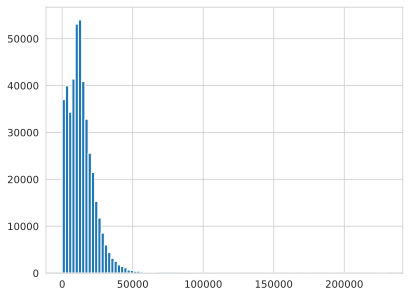

In [42]:
plt.hist(y, bins=100);

Попробуем сделать распределение целевой переменной более похожим на нормальное и заново обучить лучшую модель с предыдущего шага.

In [43]:
y_train = np.log(y_train) 
y_test = np.log(y_test)

In [44]:
p9 = Pipeline([
    ('encoder_',TargetEncoder(cols=cat_cols)), 
    ('scaler_', StandardScaler()),
    ('model_', RandomForestRegressor(n_jobs=-1))
    ])

p9.fit(X_train, y_train)
pred_p9 = p9.predict(X_test)
MAPE(np.exp(y_test), np.exp(pred_p9))

0.2757897865507731

In [45]:
MAPE(np.exp(y_test), np.exp(pred_p9))

0.2757897865507731

Качество модели возросло!

### Шаг 2

Подберем оптимальные параметры леса при помощи Optuna

In [46]:
data_pipeline = Pipeline([
        ('encoder_',TargetEncoder(cols=cat_cols)), 
        ('scaler_', StandardScaler())
]) 

X_train_good = data_pipeline.fit_transform(X_train, y_train)
X_test_good = data_pipeline.transform(X_test)

In [47]:
def objective(trial):    

    param = {
        "n_estimators": trial.suggest_int("n_estimators", 10, 1000),
        "max_features": trial.suggest_float("max_features", 0.1, 1.)
    }

    estimator = RandomForestRegressor(**param, verbose=False, n_jobs=-1)

    estimator.fit(X_train_good[:50000], y_train.iloc[:50000])
    pred = estimator.predict(X_test_good)

    return MAPE(y_test, pred)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=15)
print(study.best_trial)

[I 2023-04-10 08:54:01,603] A new study created in memory with name: no-name-cd76d1fe-2868-48ae-b76a-e0d22ccd546d
[I 2023-04-10 08:54:41,701] Trial 0 finished with value: 687671518671.3867 and parameters: {'n_estimators': 250, 'max_features': 0.7375171938033499}. Best is trial 0 with value: 687671518671.3867.
[I 2023-04-10 08:55:17,433] Trial 1 finished with value: 690675611511.9128 and parameters: {'n_estimators': 173, 'max_features': 0.972953438880839}. Best is trial 0 with value: 687671518671.3867.
[I 2023-04-10 08:56:05,202] Trial 2 finished with value: 689154892341.3196 and parameters: {'n_estimators': 476, 'max_features': 0.33764600049316135}. Best is trial 0 with value: 687671518671.3867.
[I 2023-04-10 08:56:19,353] Trial 3 finished with value: 693194332459.3279 and parameters: {'n_estimators': 125, 'max_features': 0.4776482031430104}. Best is trial 0 with value: 687671518671.3867.
[I 2023-04-10 08:57:15,584] Trial 4 finished with value: 688894834981.1143 and parameters: {'n_est

FrozenTrial(number=12, state=TrialState.COMPLETE, values=[686290659951.4847], datetime_start=datetime.datetime(2023, 4, 10, 9, 6, 22, 71727), datetime_complete=datetime.datetime(2023, 4, 10, 9, 6, 46, 95123), params={'n_estimators': 286, 'max_features': 0.25779125577992734}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=1000, log=False, low=10, step=1), 'max_features': FloatDistribution(high=1.0, log=False, low=0.1, step=None)}, trial_id=12, value=None)


## Улучшаем модель дальше

Попробуем CatBoost!

In [48]:
model = CatBoostRegressor()

model.fit(X_train_good, y_train)
pred = model.predict(X_test_good)

MAPE(np.exp(y_test), np.exp(pred))

Learning rate set to 0.102361
0:	learn: 0.8532633	total: 88.8ms	remaining: 1m 28s
1:	learn: 0.7924366	total: 124ms	remaining: 1m 2s
2:	learn: 0.7376676	total: 159ms	remaining: 52.9s
3:	learn: 0.6898038	total: 197ms	remaining: 49.1s
4:	learn: 0.6475480	total: 235ms	remaining: 46.7s
5:	learn: 0.6106222	total: 273ms	remaining: 45.2s
6:	learn: 0.5784327	total: 314ms	remaining: 44.6s
7:	learn: 0.5494630	total: 348ms	remaining: 43.1s
8:	learn: 0.5237365	total: 381ms	remaining: 42s
9:	learn: 0.5017137	total: 425ms	remaining: 42.1s
10:	learn: 0.4819299	total: 461ms	remaining: 41.4s
11:	learn: 0.4644676	total: 495ms	remaining: 40.8s
12:	learn: 0.4494632	total: 552ms	remaining: 41.9s
13:	learn: 0.4365148	total: 586ms	remaining: 41.3s
14:	learn: 0.4244131	total: 619ms	remaining: 40.7s
15:	learn: 0.4138899	total: 661ms	remaining: 40.6s
16:	learn: 0.4049290	total: 694ms	remaining: 40.2s
17:	learn: 0.3972303	total: 728ms	remaining: 39.7s
18:	learn: 0.3901694	total: 763ms	remaining: 39.4s
19:	learn: 

0.25777342983647084

Подберем гиперпараметры catboost

In [49]:
def objective(trial):    

    param = {
        "n_estimators": trial.suggest_int("n_estimators", 10, 1000),
        "max_depth": trial.suggest_int("max_depth", 2, 16),
    }

    estimator = CatBoostRegressor(**param, verbose=False)

    estimator.fit(X_train_good[:50000], y_train.iloc[:50000])
    pred = estimator.predict(X_test_good)

    return MAPE(np.exp(y_test), np.exp(pred))

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=15)
print(study.best_trial)

[I 2023-04-10 09:08:01,870] A new study created in memory with name: no-name-8a71a919-018a-4ad0-ad6a-bb2b4861604a
[I 2023-04-10 09:08:06,866] Trial 0 finished with value: 0.27534964002002954 and parameters: {'n_estimators': 999, 'max_depth': 4}. Best is trial 0 with value: 0.27534964002002954.
[I 2023-04-10 09:08:08,919] Trial 1 finished with value: 0.3028739298193997 and parameters: {'n_estimators': 507, 'max_depth': 2}. Best is trial 0 with value: 0.27534964002002954.
[I 2023-04-10 09:08:19,589] Trial 2 finished with value: 0.2786689767779434 and parameters: {'n_estimators': 703, 'max_depth': 9}. Best is trial 0 with value: 0.27534964002002954.
[I 2023-04-10 09:08:30,177] Trial 3 finished with value: 0.3359444654504803 and parameters: {'n_estimators': 155, 'max_depth': 12}. Best is trial 0 with value: 0.27534964002002954.
[I 2023-04-10 09:08:33,613] Trial 4 finished with value: 0.3017177612915277 and parameters: {'n_estimators': 876, 'max_depth': 2}. Best is trial 0 with value: 0.275

FrozenTrial(number=8, state=TrialState.COMPLETE, values=[0.2631972555481515], datetime_start=datetime.datetime(2023, 4, 10, 9, 8, 59, 3943), datetime_complete=datetime.datetime(2023, 4, 10, 9, 9, 6, 450813), params={'n_estimators': 792, 'max_depth': 7}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=1000, log=False, low=10, step=1), 'max_depth': IntDistribution(high=16, log=False, low=2, step=1)}, trial_id=8, value=None)


In [50]:
model = CatBoostRegressor(n_estimators=477, max_depth=11)

model.fit(X_train_good, y_train)
pred_cb = model.predict(X_test_good)

MAPE(np.exp(y_test), np.exp(pred_cb))

Learning rate set to 0.186853
0:	learn: 0.7875475	total: 108ms	remaining: 51.4s
1:	learn: 0.6803144	total: 218ms	remaining: 51.8s
2:	learn: 0.5961411	total: 315ms	remaining: 49.7s
3:	learn: 0.5310476	total: 418ms	remaining: 49.4s
4:	learn: 0.4809306	total: 523ms	remaining: 49.4s
5:	learn: 0.4419190	total: 625ms	remaining: 49.1s
6:	learn: 0.4128356	total: 725ms	remaining: 48.7s
7:	learn: 0.3907238	total: 820ms	remaining: 48.1s
8:	learn: 0.3740083	total: 915ms	remaining: 47.6s
9:	learn: 0.3606618	total: 1.01s	remaining: 47.4s
10:	learn: 0.3507187	total: 1.11s	remaining: 47.1s
11:	learn: 0.3432805	total: 1.22s	remaining: 47.3s
12:	learn: 0.3373756	total: 1.32s	remaining: 47s
13:	learn: 0.3327083	total: 1.42s	remaining: 46.9s
14:	learn: 0.3285887	total: 1.52s	remaining: 46.8s
15:	learn: 0.3252917	total: 1.62s	remaining: 46.7s
16:	learn: 0.3225695	total: 1.72s	remaining: 46.5s
17:	learn: 0.3198509	total: 1.81s	remaining: 46.3s
18:	learn: 0.3171573	total: 1.91s	remaining: 46.1s
19:	learn: 0.

0.2561427051227688

Теперь пусть CatBoost сам кодирует признаки!

In [51]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 330153 entries, 283789 to 121968
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          330153 non-null  int64  
 1   model         330153 non-null  object 
 2   trim          330153 non-null  object 
 3   body          330153 non-null  object 
 4   transmission  330153 non-null  object 
 5   state         330153 non-null  object 
 6   condition     330153 non-null  float64
 7   odometer      330153 non-null  float64
 8   color         330153 non-null  object 
 9   interior      330153 non-null  object 
 10  seller        330153 non-null  object 
 11  date          330153 non-null  object 
dtypes: float64(2), int64(1), object(9)
memory usage: 32.7+ MB


In [52]:
cat_features = [1,2,3,4,5,8,9,10,11]

In [53]:
model = CatBoostRegressor(cat_features=cat_features)

model.fit(X_train, y_train)
pred = model.predict(X_test)

MAPE(np.exp(y_test), np.exp(pred))

Learning rate set to 0.102361
0:	learn: 0.8543822	total: 729ms	remaining: 12m 8s
1:	learn: 0.7943252	total: 1.25s	remaining: 10m 22s
2:	learn: 0.7388097	total: 1.72s	remaining: 9m 30s
3:	learn: 0.6914694	total: 2.15s	remaining: 8m 56s
4:	learn: 0.6504172	total: 2.5s	remaining: 8m 17s
5:	learn: 0.6107521	total: 2.85s	remaining: 7m 51s
6:	learn: 0.5747850	total: 3.22s	remaining: 7m 36s
7:	learn: 0.5441344	total: 3.58s	remaining: 7m 23s
8:	learn: 0.5180968	total: 4s	remaining: 7m 20s
9:	learn: 0.4959404	total: 4.39s	remaining: 7m 14s
10:	learn: 0.4758471	total: 4.78s	remaining: 7m 10s
11:	learn: 0.4594774	total: 5.19s	remaining: 7m 7s
12:	learn: 0.4437822	total: 5.63s	remaining: 7m 7s
13:	learn: 0.4294743	total: 6.03s	remaining: 7m 4s
14:	learn: 0.4146466	total: 6.42s	remaining: 7m 1s
15:	learn: 0.4041476	total: 6.8s	remaining: 6m 58s
16:	learn: 0.3927119	total: 7.2s	remaining: 6m 56s
17:	learn: 0.3843245	total: 7.61s	remaining: 6m 55s
18:	learn: 0.3764253	total: 8.02s	remaining: 6m 54s
1

0.2654398753215348

## Stacking и Blending

### Простое смешивание

In [54]:
pred_final = 0.3 * pred_p9 + 0.7 * pred_cb

MAPE(np.exp(y_test), np.exp(pred_final))

0.25557261003209003

### Stacking (и blending)

In [55]:
estimators = [
    ('rf', RandomForestRegressor(n_jobs=-1)),
    ('cb', CatBoostRegressor(n_estimators=477, max_depth=11))
    ]

reg = StackingRegressor(
    estimators=estimators,
    final_estimator=RandomForestRegressor(n_estimators=10, random_state=42))

In [ ]:
reg.fit(X_train_good, y_train)
pred_stacking = reg.predict(X_test_good)

MAPE(np.exp(y_test), np.exp(pred_stacking))

Learning rate set to 0.186853
0:	learn: 0.7875475	total: 206ms	remaining: 1m 38s
1:	learn: 0.6803144	total: 393ms	remaining: 1m 33s
2:	learn: 0.5961411	total: 584ms	remaining: 1m 32s
3:	learn: 0.5310476	total: 774ms	remaining: 1m 31s
4:	learn: 0.4809306	total: 940ms	remaining: 1m 28s
5:	learn: 0.4419190	total: 1.04s	remaining: 1m 21s
6:	learn: 0.4128356	total: 1.14s	remaining: 1m 16s
7:	learn: 0.3907238	total: 1.24s	remaining: 1m 12s
8:	learn: 0.3740083	total: 1.34s	remaining: 1m 9s
9:	learn: 0.3606618	total: 1.44s	remaining: 1m 7s
10:	learn: 0.3507187	total: 1.54s	remaining: 1m 5s
11:	learn: 0.3432805	total: 1.63s	remaining: 1m 3s
12:	learn: 0.3373756	total: 1.73s	remaining: 1m 1s
13:	learn: 0.3327083	total: 1.83s	remaining: 1m
14:	learn: 0.3285887	total: 1.92s	remaining: 59.2s
15:	learn: 0.3252917	total: 2.02s	remaining: 58.2s
16:	learn: 0.3225695	total: 2.11s	remaining: 57.2s
17:	learn: 0.3198509	total: 2.22s	remaining: 56.5s
18:	learn: 0.3171573	total: 2.31s	remaining: 55.7s
19:	le

## Сохранение результатов

Что сохраняем?

* Предсказания моделей
* Модели

In [ ]:
for c in test.columns:
    if test[c].dtype == 'object':
          test[c].fillna("", inplace=True)

In [ ]:
for c in test.columns:
    if test[c].dtype != 'object':
          mean = np.mean(X[c])
          test[c].fillna(mean, inplace=True)

Обрабатываем дату

In [ ]:
test['date'] = test['saledate'].apply(lambda x: x.split(" ")[1]+x.split(" ")[3])

Удаляем столбцы

In [ ]:
test.drop(['vin','make','saledate'], axis=1, inplace=True)

Преобразуем данные перед применением модели

In [ ]:
test = data_pipeline.transform(test)

Применяем модель 

In [ ]:
test_pred = model.predict(test)

Сохраняем предсказания в файл

In [ ]:
test['prediction'] = test_pred 
test[['prediction']].to_csv("test_prediction.csv", index=False)

Cохраним модель

In [ ]:
with open('model.pickle', 'wb') as f:
    pickle.dump(model, f)